In [101]:
import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )


In [102]:
import torch
import torchvision.models as models

def get_model_param_size(model):
    num_params = sum(p.numel() for p in model.parameters())
    param_size = sum(p.element_size() * p.nelement() for p in model.parameters())
    return num_params, param_size / (1024 ** 2)  # Convert bytes to MB

# Instantiate the models
resnet18 = models.resnet18(weights=None)  # No pretrained weights
resnet50 = models.resnet50(weights=None)  # No pretrained weights

# Get parameter sizes
num_params_resnet18, param_size_resnet18 = get_model_param_size(resnet18)
num_params_resnet50, param_size_resnet50 = get_model_param_size(resnet50)

print(f"ResNet-18: Number of parameters = {num_params_resnet18}, Parameter size = {param_size_resnet18:.2f} MB")
print(f"ResNet-50: Number of parameters = {num_params_resnet50}, Parameter size = {param_size_resnet50:.2f} MB")


ResNet-18: Number of parameters = 11689512, Parameter size = 44.59 MB
ResNet-50: Number of parameters = 25557032, Parameter size = 97.49 MB


Files already downloaded and verified
Files already downloaded and verified


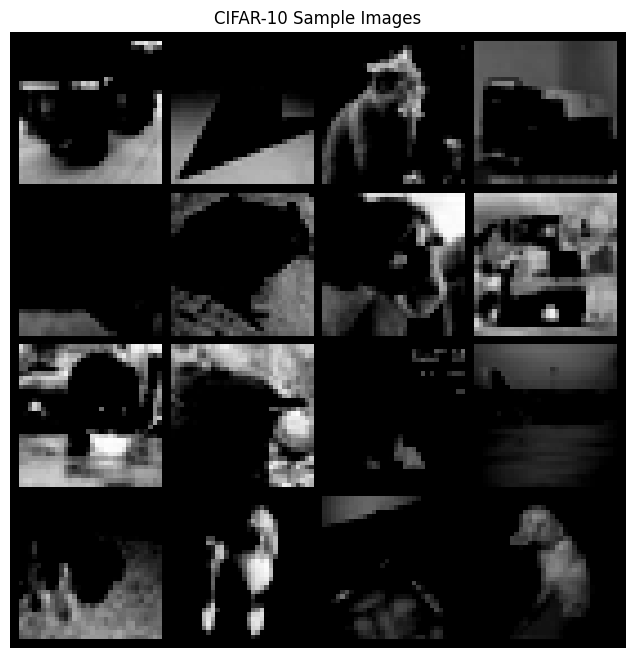

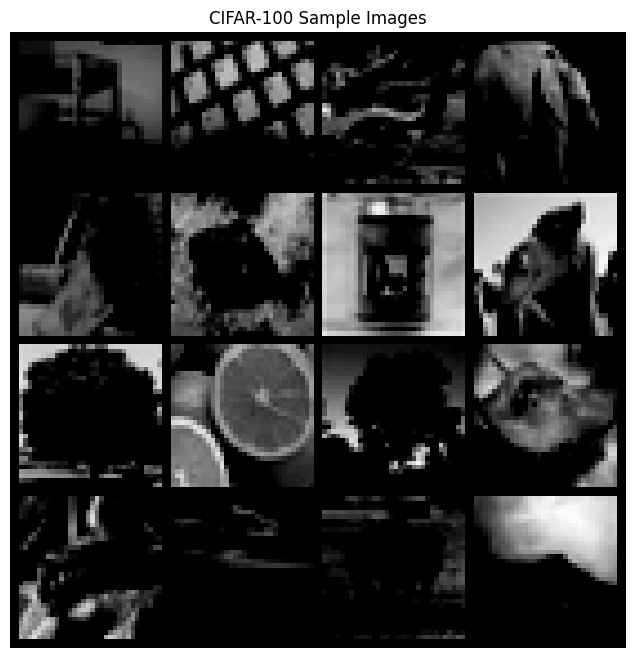

In [103]:

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchvision import models

import os

# Set CUDA_LAUNCH_BLOCKING to get accurate stack trace
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Check devices
cpu_device = torch.device("cpu")
gpu_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define datasets and transformations
transform_cifar = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_cifar)

batch_size = 16  # Reduced batch size for faster testing

# Data loaders
cifar10_loader = torch.utils.data.DataLoader(cifar10, batch_size=batch_size, shuffle=True)
cifar100_loader = torch.utils.data.DataLoader(cifar100, batch_size=batch_size, shuffle=True)

# Visualize datasets
def visualize_dataset(loader, title):
    batch = next(iter(loader))
    images, labels = batch
    plt.figure(figsize=(8, 8))
    grid_img = torchvision.utils.make_grid(images[:16], nrow=4)
    plt.imshow(grid_img.permute(1, 2, 0), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

visualize_dataset(cifar10_loader, "CIFAR-10 Sample Images")
visualize_dataset(cifar100_loader, "CIFAR-100 Sample Images")



In [104]:
import timm

In [105]:
# Adjust models for different datasets
def modify_model_input_channels(model, in_channels):
    if isinstance(model, models.ResNet):
        model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    elif isinstance(model, models.VGG):
        model.features[0] = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1)
    return model

# Define training and evaluation functions
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    epoch_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            # Flatten the inputs only if the model is KAN
            if isinstance(model, KAN):
                inputs = inputs.view(inputs.size(0), -1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    return epoch_losses

def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Flatten the inputs only if the model is KAN
            if isinstance(model, KAN):
                inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

def model_summary(model):
    summary_str = str(model)
    num_params = sum(p.numel() for p in model.parameters())
    param_size = sum(p.element_size() * p.nelement() for p in model.parameters())
    return summary_str, num_params, param_size

# Pretty print results function
def pretty_print_results(row):
    print(f"Model: {row['Model']}")
    print(f"Dataset: {row['Dataset']}")
    print(f"Epochs: {row['Epochs']}")
    print(f"Accuracy: {row['Accuracy']:.2f}%")
    print(f"Training Time: {row['Training Time']:.2f}s")
    print(f"Number of Parameters: {row['Parameters']}")
    print(f"Parameter Size: {row['Param Size'] / 1e6:.2f} MB")
    print(f"Device: {row['Device']}")

# Initialize DataFrame to track results
results_df = pd.DataFrame(columns=["Model", "Dataset", "Epochs", "Accuracy", "Training Time", "Parameters", "Param Size", "Model Summary", "Device"])

# Define KAN models first
hidden_layers_list = [
    [32*32, 256, 512, 10],  # 2 layers
    [32*32, 256, 1024, 512, 10],  # 3 layers
    [32*32, 512, 1024, 512, 256, 10],  # 4 layers
]

grid_sizes = [6, 12]  # Adjusted grid sizes to match 32x32 images
prune_options = [False]  # Prune or not

models_to_test = {}

for layers in hidden_layers_list:
    for grid_size in grid_sizes:
        for prune in prune_options:
            input_size = 32 * 32  # 1024 for 32x32 images (grayscale)
            models_to_test[f"E-KAN_{len(layers)}_layers_grid_{grid_size}"] = KAN(layers, grid_size)

# Define other models to test for CIFAR-10
models_to_test.update({
    "ResNet18_CIFAR10": modify_model_input_channels(models.resnet18(weights=None, num_classes=10), 1),
    "ResNet50_CIFAR10": modify_model_input_channels(models.resnet50(weights=None, num_classes=10), 1),

})

# Define number of epochs to test
epoch_list = [ 4,  12]  # Set to 1 for testing

# Function to save results
def save_results(df, file_name):
    df.to_csv(file_name, index=False)

# Function to load results if available
def load_results(file_name):
    try:
        return pd.read_csv(file_name)
    except FileNotFoundError:
        return pd.DataFrame(columns=["Model", "Dataset", "Epochs", "Accuracy", "Training Time", "Parameters", "Param Size", "Model Summary", "Device"])

results_file = "model_results_CIFAR10.csv"
results_df = load_results(results_file)
# Function to plot histogram

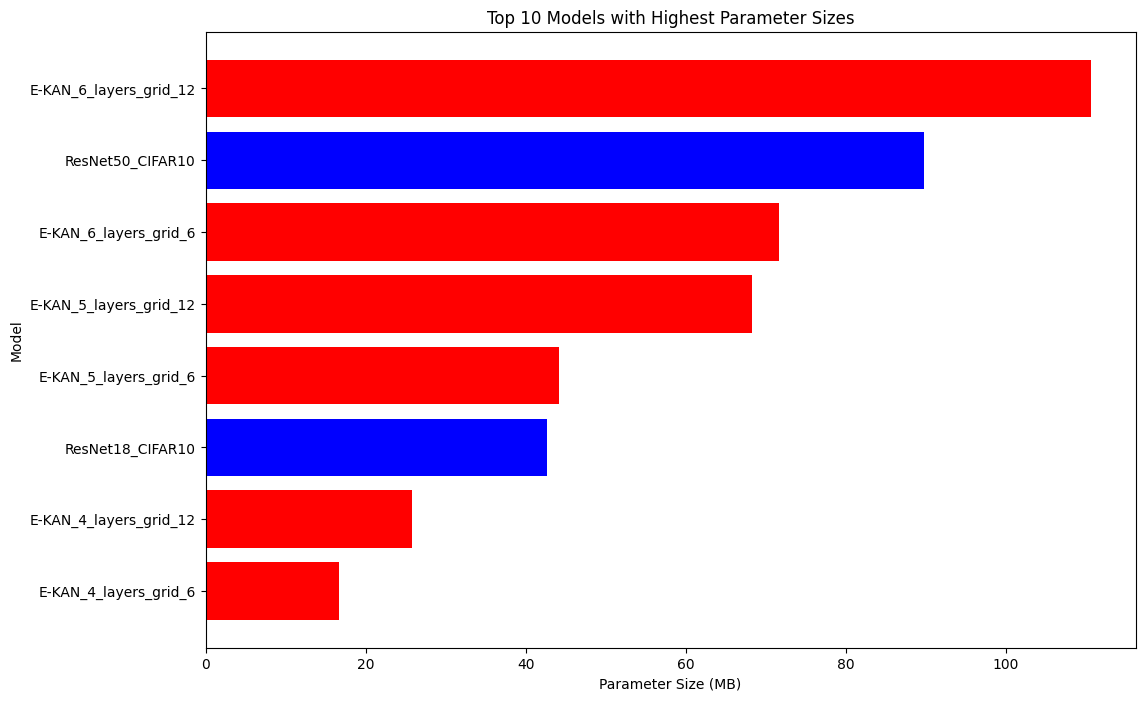

In [106]:
def plot_param_size_histogram(models_summary):
    # Extracting the top 10 models with highest parameter sizes
    sorted_models = sorted(models_summary, key=lambda x: x[2], reverse=True)[:30]
    model_names = [x[0] for x in sorted_models]
    param_sizes = [x[2] / (1024 ** 2) for x in sorted_models]  # Convert to MB

    colors = ['red' if 'KAN' in name else 'blue' for name in model_names]

    plt.figure(figsize=(12, 8))
    plt.barh(model_names, param_sizes, color=colors)
    plt.xlabel('Parameter Size (MB)')
    plt.ylabel('Model')
    plt.title('Top 10 Models with Highest Parameter Sizes')
    plt.gca().invert_yaxis()
    plt.show()

    
    
models_summary = []
for model_name, model in models_to_test.items():
    summary_str, num_params, param_size = model_summary(model)
    models_summary.append((model_name, num_params, param_size))

# Plot the histogram
plot_param_size_histogram(models_summary)

In [107]:
import pandas as pd

# Function to load results if available
def load_results(file_name):
    try:
        return pd.read_csv(file_name)
    except FileNotFoundError:
        return pd.DataFrame(columns=["Model", "Dataset", "Epochs", "Accuracy", "Training Time", "Parameters", "Param Size", "Device"])

# Function to append new results and save to the CSV file
def save_results(file_name, new_data):
    results = load_results(file_name)
    results = pd.concat([results, new_data], ignore_index=True)
    results.to_csv(file_name, index=False)

    
# Convert experiment data to DataFrame
experiment_df = pd.DataFrame(load_results('model_results_CIFAR10.csv'))


print(experiment_df)


                     Model   Dataset  Epochs  Accuracy  Training Time  \
0    E-KAN_4_layers_grid_6  CIFAR-10       4     66.11         169.17   
1    E-KAN_4_layers_grid_6  CIFAR-10      12     90.40         507.61   
2   E-KAN_4_layers_grid_12  CIFAR-10       4     69.50         179.92   
3   E-KAN_4_layers_grid_12  CIFAR-10      12     88.15         537.68   
4    E-KAN_5_layers_grid_6  CIFAR-10       4     59.77         231.27   
5    E-KAN_5_layers_grid_6  CIFAR-10      12     83.08         696.30   
6   E-KAN_5_layers_grid_12  CIFAR-10       4     64.78         262.49   
7   E-KAN_5_layers_grid_12  CIFAR-10      12     67.01         812.78   
8    E-KAN_6_layers_grid_6  CIFAR-10       4     62.89         304.18   
9    E-KAN_6_layers_grid_6  CIFAR-10      12     82.34         914.96   
10  E-KAN_6_layers_grid_12  CIFAR-10       4     62.72         336.86   
11  E-KAN_6_layers_grid_12  CIFAR-10      12     69.23        1027.74   
12        ResNet18_CIFAR10  CIFAR-10       4     79

# Visualizations of results

In [108]:

results_df=experiment_df

# Train and evaluate each model on CIFAR-10 on GPU
for model_name, model in models_to_test.items():
    for num_epochs in epoch_list:
        for device_type in [gpu_device]:
            record_exists = ((results_df['Model'] == model_name) & 
                             (results_df['Dataset'] == "CIFAR-10") & 
                             (results_df['Epochs'] == num_epochs) & 
                             (results_df['Device'] == "GPU")).any()

            if record_exists:
                print(f"Record exists for Model: {model_name}, Epochs: {num_epochs}, Device: GPU. Skipping training.")
            else:
                print(f"Training Model: {model_name}, Epochs: {num_epochs}, Device: GPU.")
                device = device_type
                model.to(device)
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
                scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
                start_time = time.time()
                epoch_losses = train_model(model, cifar10_loader, criterion, optimizer, num_epochs=num_epochs)
                train_time = time.time() - start_time
                accuracy = evaluate_model(model, cifar10_loader, criterion)
                summary_str, num_params, param_size = model_summary(model)

                device_name = "GPU" if device_type == gpu_device else "CPU"

            # Save results to DataFrame
                new_row = pd.DataFrame({
                    "Model": [model_name],
                "Dataset": ["CIFAR-10"],
                "Epochs": [num_epochs],
                "Accuracy": [accuracy],
                "Training Time": [train_time],
                "Parameters": [num_params],
                "Param Size": [param_size],
                "Model Summary": [summary_str],
                "Device": [device_name]
                })
                results_df = pd.concat([results_df, new_row], ignore_index=True)
                save_results(results_df, results_file)
                pretty_print_results(new_row.iloc[0])


Record exists for Model: E-KAN_4_layers_grid_6, Epochs: 4, Device: GPU. Skipping training.
Record exists for Model: E-KAN_4_layers_grid_6, Epochs: 12, Device: GPU. Skipping training.
Record exists for Model: E-KAN_4_layers_grid_12, Epochs: 4, Device: GPU. Skipping training.
Record exists for Model: E-KAN_4_layers_grid_12, Epochs: 12, Device: GPU. Skipping training.
Record exists for Model: E-KAN_5_layers_grid_6, Epochs: 4, Device: GPU. Skipping training.
Record exists for Model: E-KAN_5_layers_grid_6, Epochs: 12, Device: GPU. Skipping training.
Record exists for Model: E-KAN_5_layers_grid_12, Epochs: 4, Device: GPU. Skipping training.
Record exists for Model: E-KAN_5_layers_grid_12, Epochs: 12, Device: GPU. Skipping training.
Record exists for Model: E-KAN_6_layers_grid_6, Epochs: 4, Device: GPU. Skipping training.
Record exists for Model: E-KAN_6_layers_grid_6, Epochs: 12, Device: GPU. Skipping training.
Record exists for Model: E-KAN_6_layers_grid_12, Epochs: 4, Device: GPU. Skipping

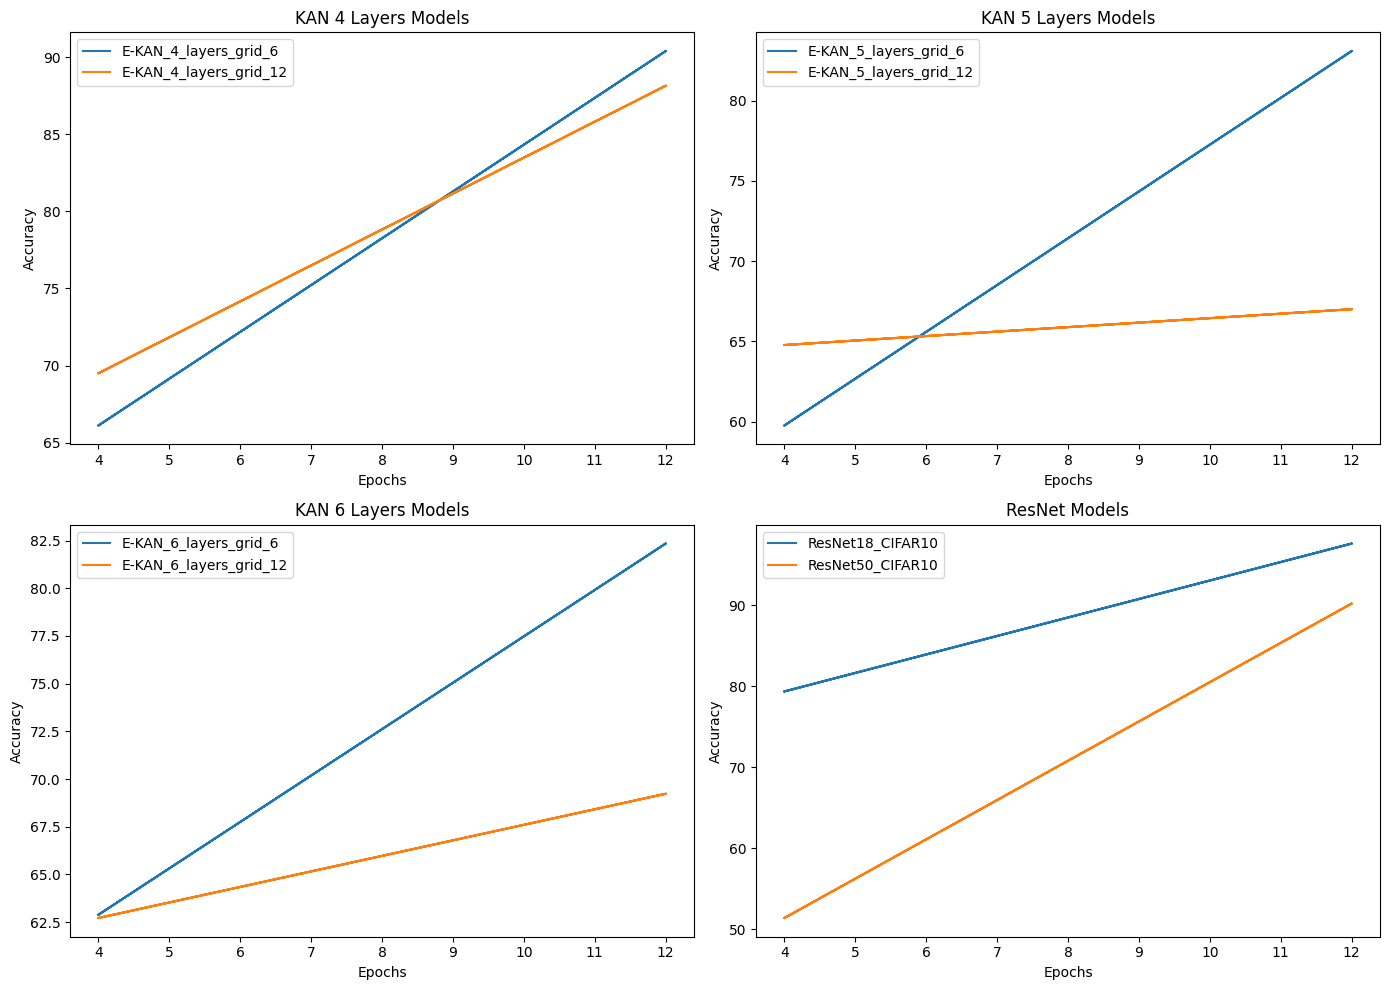

In [109]:
import matplotlib.pyplot as plt

# Assuming experiment_df is already defined and contains the results
# Filter out specific models for plotting
kan_4_layers_models = experiment_df[experiment_df['Model'].str.contains('4_layers')]
kan_5_layers_models = experiment_df[experiment_df['Model'].str.contains('5_layers')]
kan_6_layers_models = experiment_df[experiment_df['Model'].str.contains('6_layers')]
resnet_models = experiment_df[experiment_df['Model'].str.contains('ResNet')]

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot KAN 4 layers models
for model_name in kan_4_layers_models['Model'].unique():
    subset = kan_4_layers_models[kan_4_layers_models['Model'] == model_name]
    axs[0, 0].plot(subset['Epochs'], subset['Accuracy'], label=model_name)
axs[0, 0].set_title('KAN 4 Layers Models')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()

# Plot KAN 5 layers models
for model_name in kan_5_layers_models['Model'].unique():
    subset = kan_5_layers_models[kan_5_layers_models['Model'] == model_name]
    axs[0, 1].plot(subset['Epochs'], subset['Accuracy'], label=model_name)
axs[0, 1].set_title('KAN 5 Layers Models')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

# Plot KAN 6 layers models
for model_name in kan_6_layers_models['Model'].unique():
    subset = kan_6_layers_models[kan_6_layers_models['Model'] == model_name]
    axs[1, 0].plot(subset['Epochs'], subset['Accuracy'], label=model_name)
axs[1, 0].set_title('KAN 6 Layers Models')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()

# Plot ResNet models
for model_name in resnet_models['Model'].unique():
    subset = resnet_models[resnet_models['Model'] == model_name]
    axs[1, 1].plot(subset['Epochs'], subset['Accuracy'], label=model_name)
axs[1, 1].set_title('ResNet Models')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


# Notable observations and experimnts conducted

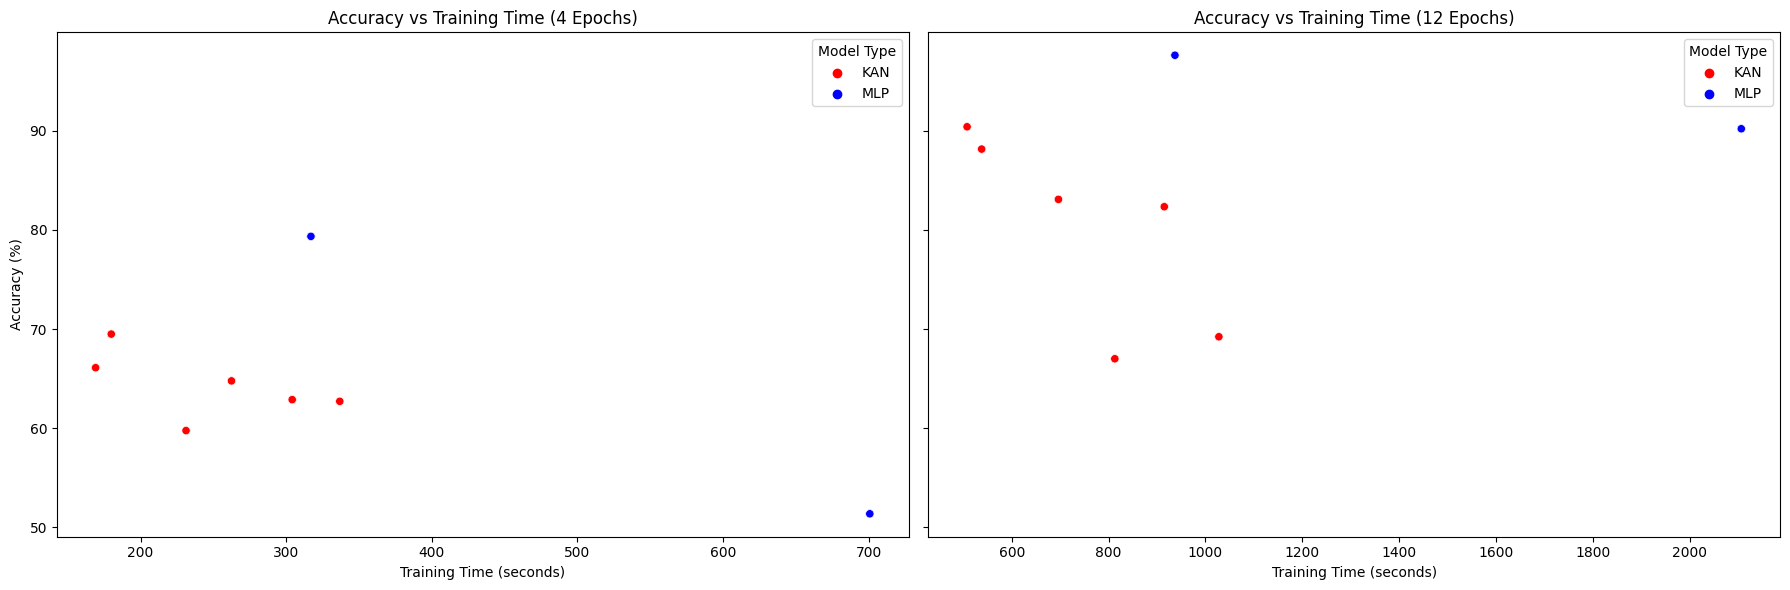

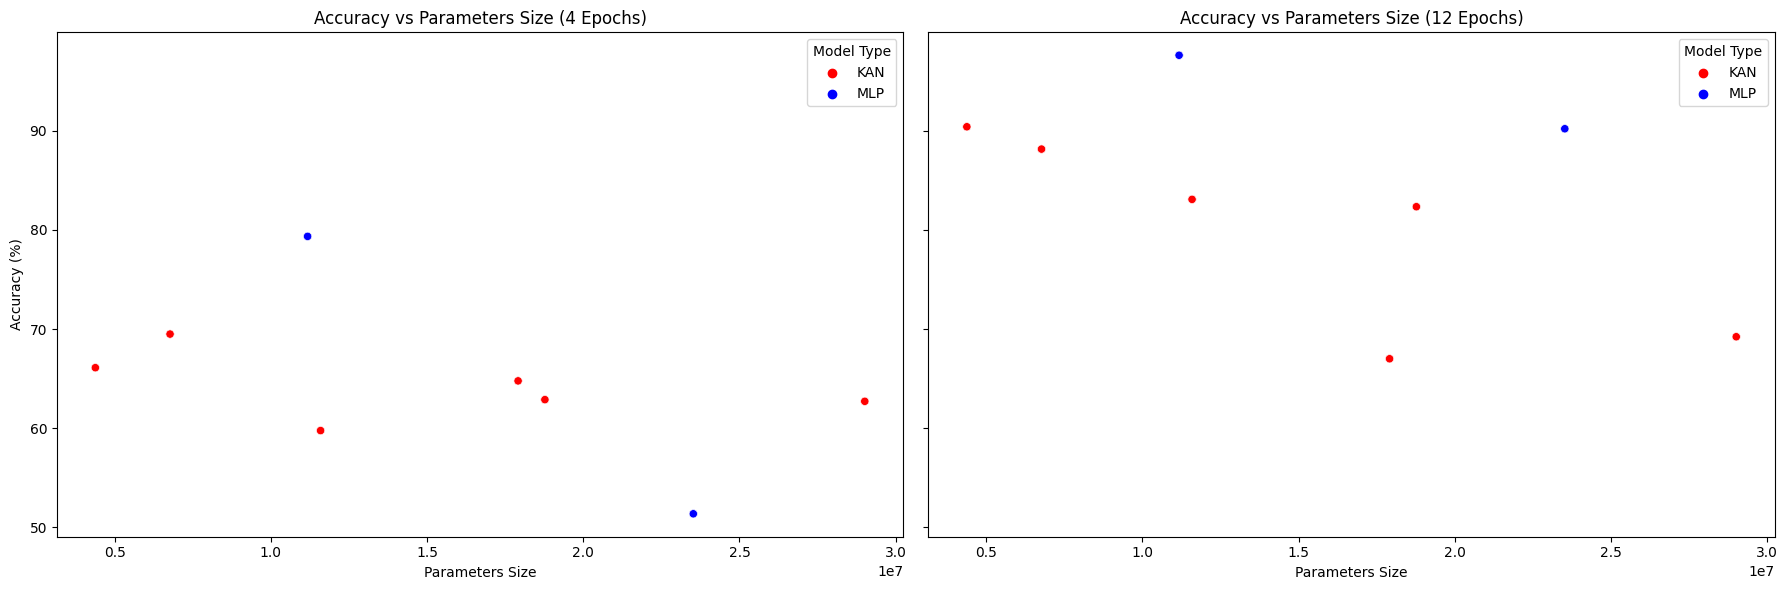

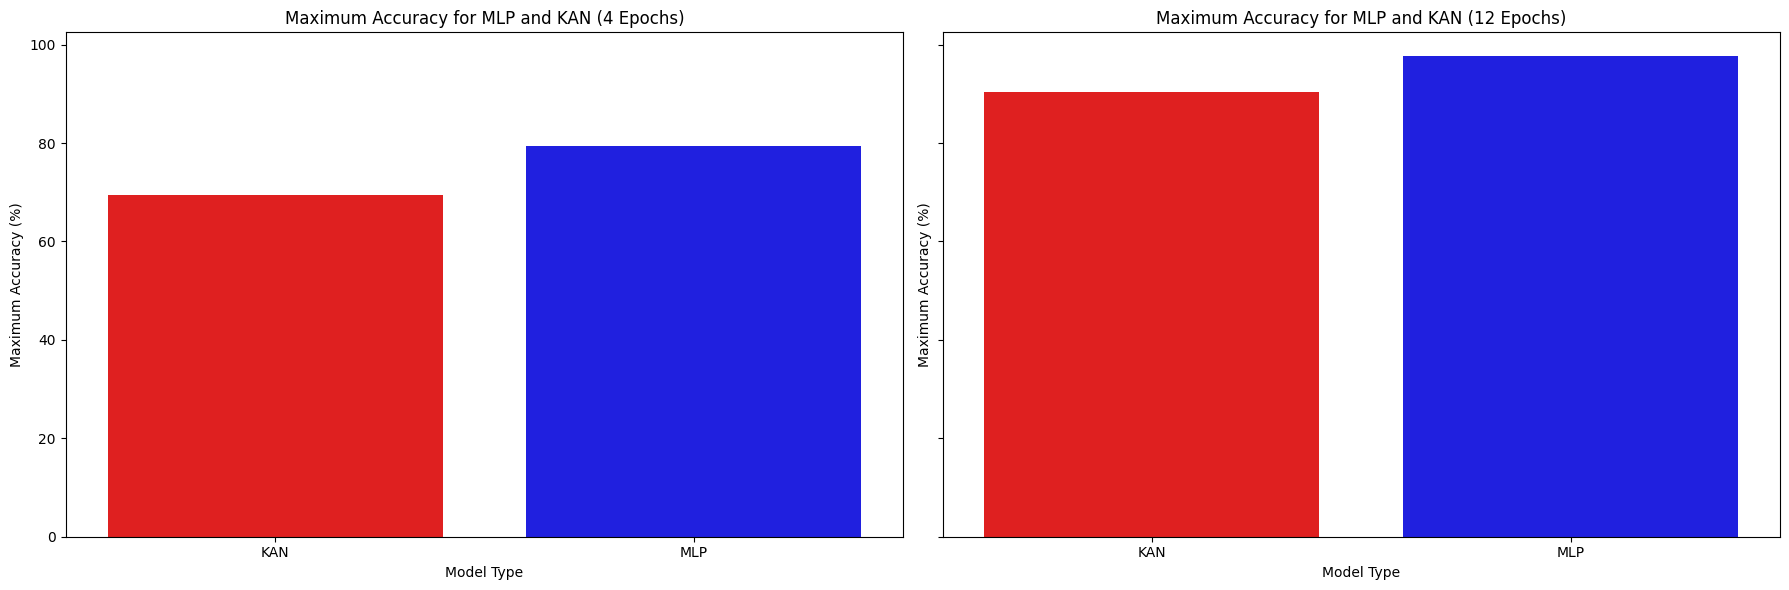

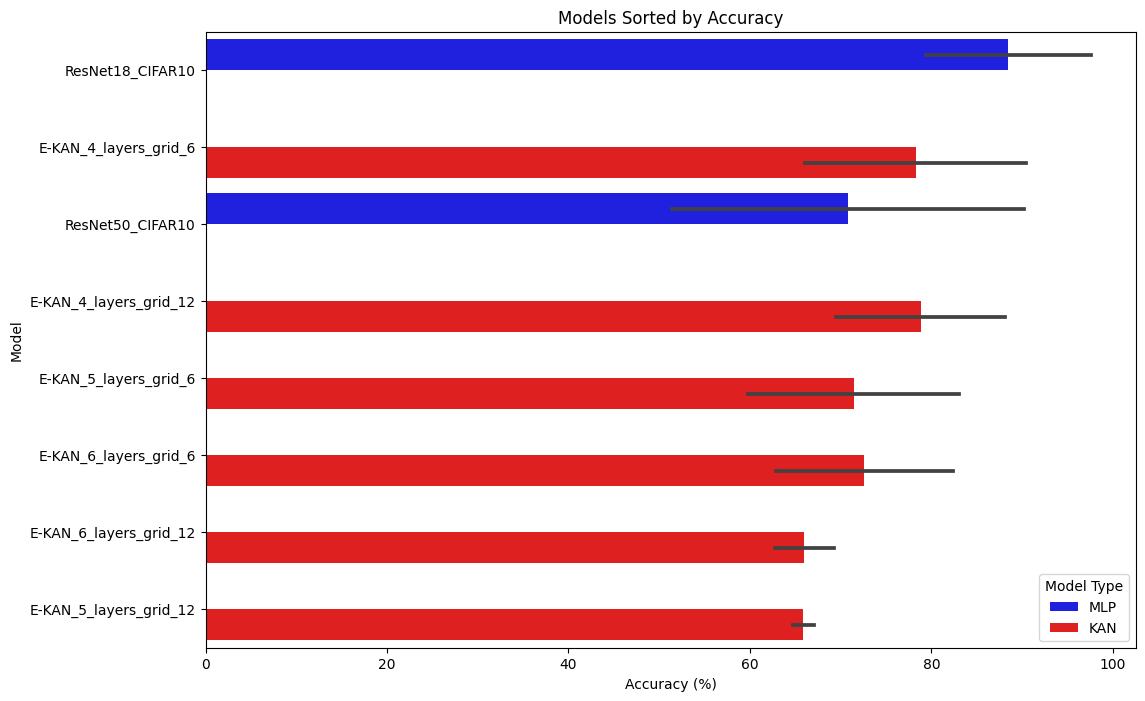

In [110]:
import seaborn as sns


# Function to extract if a model is MLP or KAN
def model_type(model_name):
    if 'E-KAN' in model_name:
        return 'KAN'
    else:
        return 'MLP'

results_df['Model Type'] = results_df['Model'].apply(model_type)


# Plot 1: Accuracy vs Training Time split by Epochs
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
sns.scatterplot(data=results_df[results_df['Epochs'] == 4], x='Training Time', y='Accuracy', hue='Model Type', palette={'MLP': 'blue', 'KAN': 'red'}, ax=axes[0])
axes[0].set_title('Accuracy vs Training Time (4 Epochs)')
axes[0].set_xlabel('Training Time (seconds)')
axes[0].set_ylabel('Accuracy (%)')
sns.scatterplot(data=results_df[results_df['Epochs'] == 12], x='Training Time', y='Accuracy', hue='Model Type', palette={'MLP': 'blue', 'KAN': 'red'}, ax=axes[1])
axes[1].set_title('Accuracy vs Training Time (12 Epochs)')
axes[1].set_xlabel('Training Time (seconds)')
axes[1].set_ylabel('Accuracy (%)')
plt.legend(title='Model Type')
plt.tight_layout()
plt.show()

# Plot 2: Accuracy vs Parameters Size split by Epochs
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
sns.scatterplot(data=results_df[results_df['Epochs'] == 4], x='Parameters', y='Accuracy', hue='Model Type', palette={'MLP': 'blue', 'KAN': 'red'}, ax=axes[0])
axes[0].set_title('Accuracy vs Parameters Size (4 Epochs)')
axes[0].set_xlabel('Parameters Size')
axes[0].set_ylabel('Accuracy (%)')
sns.scatterplot(data=results_df[results_df['Epochs'] == 12], x='Parameters', y='Accuracy', hue='Model Type', palette={'MLP': 'blue', 'KAN': 'red'}, ax=axes[1])
axes[1].set_title('Accuracy vs Parameters Size (12 Epochs)')
axes[1].set_xlabel('Parameters Size')
axes[1].set_ylabel('Accuracy (%)')
plt.legend(title='Model Type')
plt.tight_layout()
plt.show()

# Plot 3: Maximum Accuracy for MLP and KAN split by Epochs
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
max_accuracy_4 = results_df[results_df['Epochs'] == 4].groupby('Model Type')['Accuracy'].max().reset_index()
max_accuracy_12 = results_df[results_df['Epochs'] == 12].groupby('Model Type')['Accuracy'].max().reset_index()
sns.barplot(data=max_accuracy_4, x='Model Type', y='Accuracy', palette={'MLP': 'blue', 'KAN': 'red'}, ax=axes[0])
axes[0].set_title('Maximum Accuracy for MLP and KAN (4 Epochs)')
axes[0].set_xlabel('Model Type')
axes[0].set_ylabel('Maximum Accuracy (%)')
sns.barplot(data=max_accuracy_12, x='Model Type', y='Accuracy', palette={'MLP': 'blue', 'KAN': 'red'}, ax=axes[1])
axes[1].set_title('Maximum Accuracy for MLP and KAN (12 Epochs)')
axes[1].set_xlabel('Model Type')
axes[1].set_ylabel('Maximum Accuracy (%)')
plt.tight_layout()
plt.show()


# Sort models by Accuracy
sorted_df = results_df.sort_values(by='Accuracy', ascending=False)

# Assign colors
colors = sorted_df['Model Type'].map({'MLP': 'blue', 'KAN': 'red'})

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Accuracy', y='Model', data=sorted_df, hue='Model Type', palette={'MLP': 'blue', 'KAN': 'red'})
plt.title('Models Sorted by Accuracy')
plt.xlabel('Accuracy (%)')
plt.ylabel('Model')
plt.show()

# Grid Size Effect on KAN models